In [1]:
import os

import numpy as np
import gymnasium as gym

import gym_env
from utils import decision_policy, get_full_maze_values, replan_barrier
from utils_render import plot_decision_prob
from models import LinearRL

In [2]:
# Set the random seed for NumPy
seed = 42
np.random.seed(seed)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
# def replan_barrier(agent, T, locs, inv=False):
#     """
#     New Environment is the same as the old one, with the inclusion of a new goal state that we want to use the old DR to
#     plan towards
    
#     Args:
#     agent (LinearRL class): The LinearRL agent 
#     T (array): The transition matrix of the new environment
#     loc (tuple): Location of the new goal state
#     """
#     L0 = np.diag(np.exp(-agent.r)) - agent.T
#     if inv:
#         D0 = np.linalg.inv(L0)
#     else:
#         D0 = agent.gamma * agent.DR
#     L = np.diag(np.exp(-agent.r)) - T

#     # idx = [agent.mapping[loc], agent.mapping[(9,9)]]

#     d = L[locs, :] - L0[locs, :]
#     m0 = D0[:,locs]

#     c = np.zeros_like(m0)
#     c[locs[0], 0] = 1
#     c[locs[1], 1] = 1

#     a = np.linalg.inv(np.eye(len(locs)) + d @ D0 @ c)

#     D = D0 - (D0 @ c @ a @ d @ D0)

#     return D

def pretty_print_values(agent):
    values = get_full_maze_values(agent)
    max_width = max(len("{:.2f}".format(value)) for row in values for value in row if not np.isinf(value))

    # Print the matrix
    for row in values:
        for value in row:
            if np.isinf(value):
                print("{:>{}}".format("-inf", max_width), end=" ")
            else:
                print("{:>{}}".format("{:.2f}".format(value), max_width), end=" ")
        print()

## Learn DR-TD

In [4]:
# Hyperparams
alpha = 0.05 # 0.001
beta = 1.2
_lambda = 1.0
num_steps = 20000 # 250000

# For plotting
prob_locs = [12, 4, 6]
colors = [3, 2, 4]

In [5]:
agent_with_imp = LinearRL(env_name="tolman-9x9-nb", _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)
# agent_without_imp = LinearRL(env_name="tolman-9x9-nb", _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=False)
agent_with_imp.learn(seed=seed)
# agent_without_imp.learn(seed=seed)

In [6]:
pii_with_imp = decision_policy(agent_with_imp, agent_with_imp.Z)
# pii_without_imp = decision_policy(agent_without_imp, agent_without_imp.Z)

In [7]:
probs_train_with_imp = pii_with_imp[5][prob_locs]
probs_train_with_imp_n = probs_train_with_imp / np.sum(probs_train_with_imp)
# probs_train_without_imp = pii_without_imp[5][prob_locs]
# probs_train_without_imp_n = probs_train_without_imp / np.sum(probs_train_without_imp)

In [8]:
D_inv = agent_with_imp.get_D_inv()

In [9]:
D0_inv = np.linalg.inv(np.diag(np.exp(-agent_with_imp.r/agent_with_imp._lambda)) - agent_with_imp.T)
print("absolute error")
print(np.max(np.abs(D0_inv - agent_with_imp.gamma * D_inv)), np.mean(np.abs(D0_inv - agent_with_imp.gamma * D_inv)))
print(np.max(np.abs(D0_inv - agent_with_imp.gamma * agent_with_imp.DR)), np.mean(np.abs(D0_inv - agent_with_imp.gamma * agent_with_imp.DR)))
print(np.max(np.abs(agent_with_imp.DR - D_inv)), np.mean(np.abs(agent_with_imp.DR - D_inv)))

# print(np.max(np.abs(((agent_with_imp.gamma * D_inv) / D0_inv) - 1)), np.mean(np.abs(((agent_with_imp.gamma * D_inv) / D0_inv) - 1)))
# print(np.max(np.abs(((agent_with_imp.gamma * agent_with_imp.DR) / D0_inv) - 1)), np.mean(np.abs(((agent_with_imp.gamma * agent_with_imp.DR) / D0_inv) - 1)))
print("relative error")
print(np.max(np.abs((agent_with_imp.DR[:-1, :-1] / D_inv[:-1, :-1])-1)), np.mean(np.abs((agent_with_imp.DR[:-1, :-1] / D_inv[:-1, :-1]) - 1)))

absolute error
1.1102230246251565e-16 1.4887258835473652e-18
0.2804715264827544 0.0033480124733584284
0.7624006538382413 0.009100841467784438
relative error
175325.40337734207 2421.6463120887324


In [10]:
agent_with_imp.r

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [11]:
D0_inv = np.linalg.inv(np.diag(np.exp(-agent_with_imp.r/agent_with_imp._lambda)) - agent_with_imp.T)
print("absolute error")
print(np.max(np.abs(D0_inv - agent_with_imp.gamma * D_inv)), np.mean(np.abs(D0_inv - agent_with_imp.gamma * D_inv)))
print(np.max(np.abs(D0_inv - agent_with_imp.gamma * agent_with_imp.DR)), np.mean(np.abs(D0_inv - agent_with_imp.gamma * agent_with_imp.DR)))
print(np.max(np.abs(agent_with_imp.DR - D_inv)), np.mean(np.abs(agent_with_imp.DR - D_inv)))

# print(np.max(np.abs(((agent_with_imp.gamma * D_inv) / D0_inv) - 1)), np.mean(np.abs(((agent_with_imp.gamma * D_inv) / D0_inv) - 1)))
# print(np.max(np.abs(((agent_with_imp.gamma * agent_with_imp.DR) / D0_inv) - 1)), np.mean(np.abs(((agent_with_imp.gamma * agent_with_imp.DR) / D0_inv) - 1)))
print("relative error")
print(np.max(np.abs(agent_with_imp.DR[:-1, :-1] - D_inv[:-1, :-1]) / D_inv[:-1, :-1]), np.mean(np.abs(agent_with_imp.DR[:-1, :-1] - D_inv[:-1, :-1]) / D_inv[:-1, :-1]))

absolute error
1.1102230246251565e-16 1.4887258835473652e-18
0.2804715264827544 0.0033480124733584284
0.7624006538382413 0.009100841467784438
relative error
175325.40337734207 2421.6463120887324


In [28]:
print(D0_inv[30][30], agent_with_imp.gamma * D_inv[30][30])

0.5819767068693265 0.5819767068693265


In [29]:
# Get new maze and initialize a new agent
env_blocked = gym.make("tolman-9x9-b")
maze_blocked = env_blocked.unwrapped.maze
new_agent = LinearRL(env_name="tolman-9x9-nb", _lambda=_lambda, beta=beta, alpha=alpha)

In [30]:
# Block transition to from state 12 -> state 15
delta_locs = [12, 18, 15]
blocked_state = 15

# Make a new transition matrix that doesn't allow transition to blocked state
T_new = np.copy(agent_with_imp.T)

# Set transitions to the blocked state to 0
T_new[12, blocked_state] = 0
T_new[blocked_state, 12] = 0

# Calculate the sum of transitions for each row, excluding transitions to the blocked state
row_sums = np.sum(T_new, axis=1)

# Normalize non-zero transitions
non_zero_indices = np.where(row_sums != 0)
T_new[non_zero_indices] /= row_sums[non_zero_indices][:, np.newaxis]

### Detour with importance sampling

In [31]:
# agent_with_imp.DR[4][29] = D_inv[4][29]
# agent_with_imp.DR[4][30] = D_inv[4][30]
# agent_with_imp.DR[6][29] = D_inv[5][29]
# agent_with_imp.DR = D_inv

In [32]:
D = replan_barrier(agent_with_imp, T_new, delta_locs, inv=False)

In [33]:
# agent_with_imp.DR = D_inv
# agent_with_imp.update_V()
# pretty_print_values(agent_with_imp)

In [34]:
pretty_print_values(agent_with_imp)

  -inf   -inf   -inf -14.57   -inf   -inf   -inf   -inf   -inf 
  -inf   -inf   -inf -13.66   -inf   -inf   -inf   -inf   -inf 
-15.67 -15.12 -13.55 -11.70 -13.44 -15.21 -16.99 -18.58 -18.94 
-14.33   -inf   -inf  -9.09   -inf   -inf   -inf   -inf -17.38 
-12.94   -inf   -inf  -7.13   -inf   -inf   -inf   -inf -15.59 
-11.01   -inf   -inf  -5.61   -inf   -inf   -inf   -inf -13.82 
 -9.38  -7.29  -5.56  -4.39  -5.73  -7.27  -9.21 -10.84 -12.43 
  -inf   -inf   -inf  -1.67   -inf   -inf   -inf   -inf   -inf 
  -inf   -inf   -inf  -1.00   -inf   -inf   -inf   -inf   -inf 


In [35]:
new_agent.DR = D
new_agent.P = T_new[~new_agent.terminals][:,new_agent.terminals]
new_agent.update_V()

/Users/abizzle/Research/LinearRL-TD/src/models.py:88: RuntimeWarning: invalid value encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [36]:
pretty_print_values(new_agent)

  -inf   -inf   -inf    nan   -inf   -inf   -inf   -inf   -inf 
  -inf   -inf   -inf    nan   -inf   -inf   -inf   -inf   -inf 
-17.57    nan    nan    nan    nan    nan    nan    nan -21.34 
-15.36   -inf   -inf    nan   -inf   -inf   -inf   -inf -18.41 
-13.94   -inf   -inf  -7.50   -inf   -inf   -inf   -inf -16.59 
-12.01   -inf   -inf  -6.58   -inf   -inf   -inf   -inf -14.82 
-10.38  -8.29  -6.56  -5.39  -6.73  -8.27 -10.21 -11.84 -13.43 
  -inf   -inf   -inf  -2.67   -inf   -inf   -inf   -inf   -inf 
  -inf   -inf   -inf  -1.00   -inf   -inf   -inf   -inf   -inf 


In [42]:
pii = decision_policy(new_agent, new_agent.Z)
probs_test_with_imp = pii[5][prob_locs]
probs_test_with_imp_n = probs_test_with_imp / np.sum(probs_test_with_imp)

### Detour without importance sampling

In [43]:
D = replan_barrier(agent_without_imp, T_new, delta_locs)

NameError: name 'agent_without_imp' is not defined

In [44]:
new_agent.DR = D
new_agent.P = T_new[~new_agent.terminals][:,new_agent.terminals]
new_agent.update_V()

In [45]:
pii = decision_policy(new_agent, new_agent.Z)
probs_test_without_imp = pii[5][prob_locs]
probs_test_without_imp_n = probs_test_without_imp / np.sum(probs_test_without_imp)

## Plot Decision Probabilities

### With importance sampling

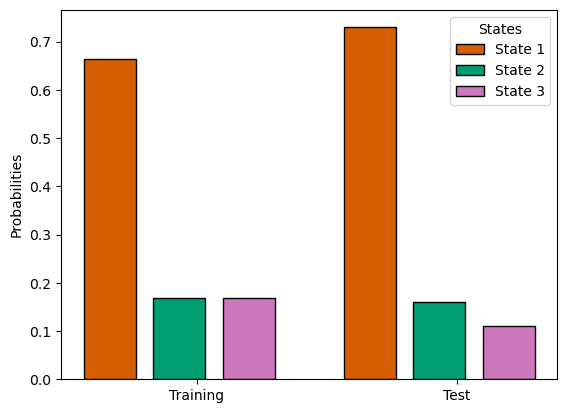

In [46]:
save_path = save_dir + 'detour_with_is.png'
plot_decision_prob(probs_train=probs_train_with_imp_n, probs_test=probs_test_with_imp_n, colors=colors, save_path=None)

### Without importance sampling

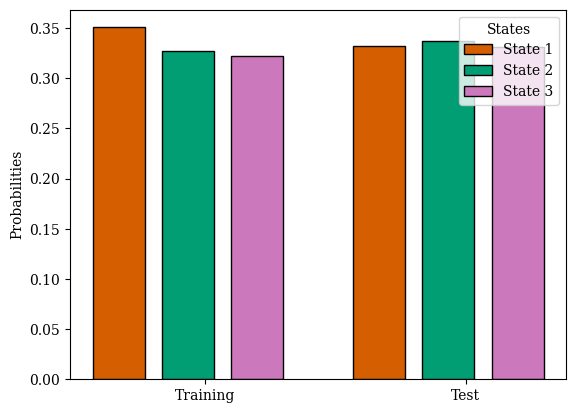

In [81]:
save_path = save_dir + 'detour_without_is.png'
plot_decision_prob(probs_train=probs_train_without_imp_n, probs_test=probs_test_without_imp_n, colors=colors, save_path=None)